# Analysis of 40,000+ Oncology Studies from [ClinicalTrials.gov](www.clinicaltrials.gov)

On August 18, 2016 I downloaded data on 43,692 clinical trials from the government registry [ClinicalTrials.gov](www.clinicaltrials.gov). I limited my search to all oncology-related trials in the database (there are over 200,000 trials in total). To cast as wide a net as possible, I included the following search terms in the "Conditions" field: cancer OR oncology OR neoplasm OR carcinoma OR leukemia OR lymphoma. After testing several combinations of terms, this set generated the largest number of search results.

In this notebook I do some initial EDA on the data, to get a feel for what needs to be cleaned. In future notebooks, I'll be generating visualizations to answer specific questions of the data. Here is where I first identify what questions I'm going to ask.

## Read in data 

In [69]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
% matplotlib inline
import seaborn as sns

In [70]:
# Read in data
trials = pd.read_csv('trials.csv')

## 1View head, shape, column headers, missing values, and data types

In [71]:
trials.head(2)

,Rank,NCT Number,Title,Recruitment,Study Results,Conditions,Interventions,Sponsor/Collaborators,Gender,Age,...,First Received,Start Date,Completion Date,Last Updated,Last Verified,Results First Received,Acronym,Primary Completion Date,Outcome Measures,URL
0,1,NCT01638533,"Romidepsin in Treating Patients With Lymphoma,...",Recruiting,No Results Available,Adult Mixed Glioma|Adult Pineal Gland Astrocyt...,Other: Pharmacological Study|Drug: Romidepsin,National Cancer Institute (NCI)|Celgene Corpor...,Both,"18 Years and older (Adult, Senior)",...,9-Jul-12,Jun-12,NaN,19-Jul-16,Apr-16,No Study Results Posted,NaN,Sep-17,Dose-limiting toxicity of romidepsin in groups...,https://ClinicalTrials.gov/show/NCT01638533
1,2,NCT01460134,A Study of CDX-1127 (Varlilumab) in Patients W...,"Active, not recruiting",No Results Available,"CD27 Expressing B-cell Malignancies, (for Exam...",Drug: CDX-1127|Drug: CDX-1127|Drug: CDX-1127,Celldex Therapeutics,Both,"18 Years and older (Adult, Senior)",...,12-Oct-11,Oct-11,Dec-16,5-Apr-16,Apr-16,No Study Results Posted,NaN,Dec-15,Characterize the adverse events associated wit...,https://ClinicalTrials.gov/show/NCT01460134


In [72]:
trials.shape

(43962, 26)

In [73]:
# View column headers
trials.columns.values

array(['Rank', 'NCT Number', 'Title', 'Recruitment', 'Study Results',
       'Conditions', 'Interventions', 'Sponsor/Collaborators', 'Gender',
       'Age', 'Phases', 'Enrollment', 'Funded Bys', 'Study Types',
       'Study Designs', 'Other IDs', 'First Received', 'Start Date',
       'Completion Date', 'Last Updated', 'Last Verified',
       'Results First Received', 'Acronym', 'Primary Completion Date',
       'Outcome Measures', 'URL'], dtype=object)

In [74]:
# View number of null values by column
pd.DataFrame(trials.isnull().sum())

,0
Rank,0
NCT Number,0
Title,0
Recruitment,0
Study Results,0
Conditions,0
Interventions,4253
Sponsor/Collaborators,0
Gender,43
Age,0


In [75]:
# view data types
pd.DataFrame(trials.dtypes)

,0
Rank,int64
NCT Number,object
Title,object
Recruitment,object
Study Results,object
Conditions,object
Interventions,object
Sponsor/Collaborators,object
Gender,object
Age,object


## Visualize counts of different fields

/Applications/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


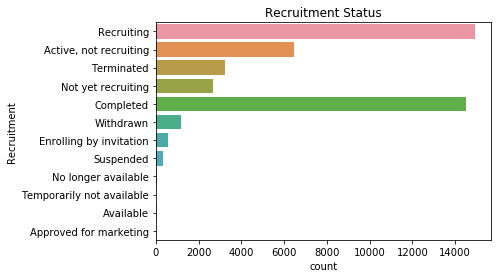

In [76]:
ax = sns.countplot(y="Recruitment", data=trials, orient='h')
ax.set_title('Recruitment Status')

/Applications/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


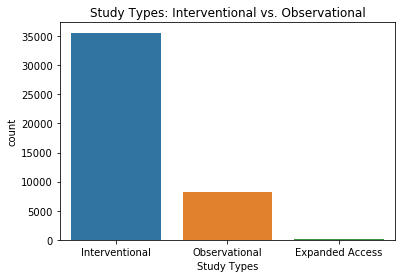

In [77]:
ax = sns.countplot(x='Study Types', data=trials)
ax.set_title('Study Types: Interventional vs. Observational')

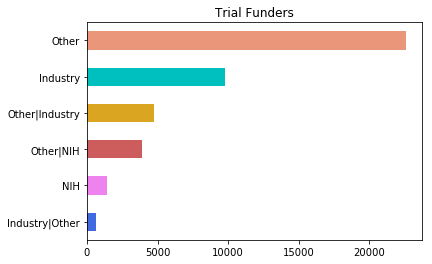

In [78]:
# get top six categories of trial funders
top_funded_bys = trials['Funded Bys'].value_counts().sort_values(ascending=True)[-6:]

# plot it with pandas
colors = ['royalblue', 'violet', 'indianred', 'goldenrod', 'c', 'darksalmon']
top_funded_bys.plot(kind='barh', color=colors, title='Trial Funders')

# 2. What cancers are most commonly studied?
---

##### a. For example, how many trials for cervical cancer are there?

In [79]:
# Search the "Conditions" column for cells that contain "cerv" for "cervical"
trials['Conditions'].str.contains('cerv', case=False).value_counts()

False    43264
True       698
Name: Conditions, dtype: int64

##### b. Another example: kidney cancer is also called renal cell carcinoma. How many trials are there for either of these?

In [80]:
# Slice dataframe to get value counts for kidney cancer/renal cell carcinoma
((trials['Conditions'].str.contains('renal', case=False)) | 
          (trials['Conditions'].str.contains('kidney', case=False))).value_counts()[True]

1135

##### c. Add a dummy column for each of the major cancer types

In [81]:
# List of cancer sites
cancer_sites = [('breast', 'Breast'), ('lung', 'Lung'), ('colo', 'Colorectal'), ('prostate', 'Prostate'),
                ('pancrea', 'Pancreatic'), ('thyroid', 'Thyroid'), ('ovar', 'Ovarian'), ('melanoma', 'Melanoma'),
               ('esoph', 'Esophageal'), ('myeloma', 'Multiple Myeloma'), ('lymphoma', 'Lymphomas'),
                ('leukemia', 'Leukemias'), ('uter', 'Uterine'), ('bladder', 'Bladder'), ('cerv', 'Cervical'),
               ('head and neck', 'Head and Neck'), ('liver', 'Liver'), ('testi', 'Testicular')]

In [82]:
# Add columns for cancer sites
for search_term, site in cancer_sites:
    trials[site] = trials.Conditions.str.contains(search_term, case=False)
    trials[site] = trials[site].map({True:1, False:0})

In [83]:
trials.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43962 entries, 0 to 43961
Data columns (total 44 columns):
Rank                       43962 non-null int64
NCT Number                 43962 non-null object
Title                      43962 non-null object
Recruitment                43962 non-null object
Study Results              43962 non-null object
Conditions                 43962 non-null object
Interventions              39709 non-null object
Sponsor/Collaborators      43962 non-null object
Gender                     43919 non-null object
Age                        43962 non-null object
Phases                     28460 non-null object
Enrollment                 43543 non-null float64
Funded Bys                 43962 non-null object
Study Types                43962 non-null object
Study Designs              43444 non-null object
Other IDs                  43954 non-null object
First Received             43962 non-null object
Start Date                 43602 non-null object
Completio

In [84]:
# List of cancer sites with multiple names
cancer_sites_mult_names = [(('brain', 'glio'), 'Brain'), (('kidney', 'renal'), 'Kidney'), (('stomach', 'gastric'), 'Gastric'),
                           (('bone', 'osteos'), 'Bone'), (('soft tissue', 'gastrointestinal stromal'), 'Soft-tissue')]

In [85]:
# Add additional columns for cancer sites with multiple search terms
for search_terms, site in cancer_sites_mult_names:
    trials[site] = ((trials.Conditions.str.contains(search_terms[0], case=False)) | 
                     (trials.Conditions.str.contains(search_terms[1], case=False)))
    trials[site] = trials[site].map({True:1, False:0})

##### e. Graph the data with matplotlib

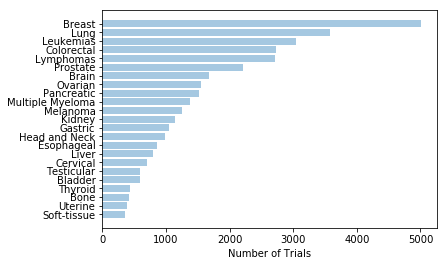

In [86]:
# Number of cancer sites - for number of bars on plot
num_cancer_sites = np.arange(len(cancer_sites) + len(cancer_sites_mult_names))

# Trial totals - for length of bars
trial_totals_by_site = trials.iloc[:, -23:].sum().sort_values(ascending=False).values

# Names of cancer sites - for bar labels
cancer_sites_high_to_low = trials.iloc[:, -23:].sum().sort_values(ascending=False).index

# Create horizontal bar
plt.barh(num_cancer_sites, trial_totals_by_site, align='center', alpha=0.4)

# Create yticks
plt.yticks(num_cancer_sites, cancer_sites_high_to_low)

# Create xlabel
plt.xlabel('Number of Trials')

# Invert graph
plt.gca().invert_yaxis()

# 3. What's the distribution of sponsors in the data set?
---

##### a. Clean text data

In [87]:
# split pipe delimited sponsor names into a list in each cell
s = trials['Sponsor/Collaborators'].str.split('|')

In [88]:
# The lead sponsor is the first one listed - generate new list with only lead sponsor
lead_sponsors = [row[0] for row in s]

In [89]:
# Turn lead_sponsors list to a pandas series
lead_sponsors_series = pd.Series(lead_sponsors)

In [90]:
# Get value counts
lead_sponsors_series.value_counts().sort_values(ascending=False)[:50]

M.D. Anderson Cancer Center                                 1387
National Cancer Institute (NCI)                             1263
Memorial Sloan Kettering Cancer Center                       854
Hoffmann-La Roche                                            605
Novartis Pharmaceuticals                                     478
Mayo Clinic                                                  403
AstraZeneca                                                  400
Pfizer                                                       320
Dana-Farber Cancer Institute                                 300
GlaxoSmithKline                                              299
Massachusetts General Hospital                               299
Washington University School of Medicine                     292
Eli Lilly and Company                                        289
Bristol-Myers Squibb                                         284
University Health Network, Toronto                           273
Sidney Kimmel Comprehensi

##### b. Plot top sponsors

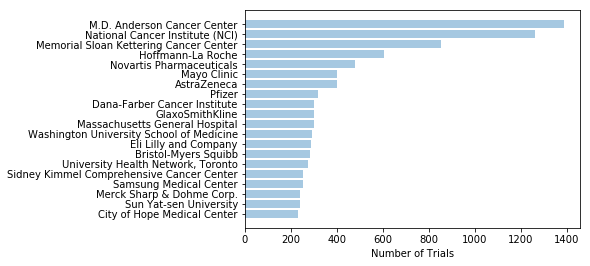

In [91]:
# Number of cancer sites - for number of bars on plot
num_sponsors = np.arange(20)

# Trial totals - for length of bars
trial_totals_by_sponsor = lead_sponsors_series.value_counts().sort_values(ascending=False)[:20].values

# Names of cancer sites - for bar labels
sponsor_names = lead_sponsors_series.value_counts().sort_values(ascending=False)[:20].index

# Create horizontal bar
plt.barh(num_sponsors, trial_totals_by_sponsor, align='center', alpha=0.4)

# Create yticks
plt.yticks(num_sponsors, sponsor_names)

# Create xlabel
plt.xlabel('Number of Trials')

# Invert graph
plt.gca().invert_yaxis()

# 4. How large are cancer trials?
---

##### a. Clean up necessary columns
I had to convert the "Enrollment" column to numeric data type, drop NaNs, investigate possible outliers, and remove trials with recruitment status of "Withdrawn"

In [92]:
# Convert to numeric
trials['Enrollment'] = pd.to_numeric(trials.Enrollment, errors='coerce')

In [93]:
trials.Enrollment.isnull().sum()

419

In [94]:
# Create a new series without the nans
without_nulls_enrollment = trials[['NCT Number', 'Enrollment', 'Study Types', 'Recruitment']].dropna()

In [95]:
# alright, clear outlier
without_nulls_enrollment['Enrollment'].max()

99999999.0

In [96]:
# View all the trials with enrollment of greater than 20k
without_nulls_enrollment[without_nulls_enrollment['Enrollment'] > 20000].shape

(173, 4)

In [97]:
# How many interventional trials with greater than 100k participants?
# There are still a good number of trials with over 100k participants, so not comfortable removing outliers
# I would need to remove outliers if I wanted to do a swarm plot
without_nulls_enrollment[without_nulls_enrollment['Enrollment'] > 100000]['Study Types'].value_counts()

Observational     37
Interventional     9
Name: Study Types, dtype: int64

In [98]:
# View enrollment stats based on each recruitment category
without_nulls_enrollment.groupby('Recruitment').agg([np.mean, np.count_nonzero,])

Enrollment              
                                 mean count_nonzero
Recruitment                                        
Active, not recruiting    1011.809568        6417.0
Completed                 3356.210996       14349.0
Enrolling by invitation   7005.757366         577.0
Not yet recruiting         474.389142        2634.0
Recruiting               21934.732221       14861.0
Suspended                  144.589172         314.0
Terminated                  63.077882        3201.0
Withdrawn                    4.615123          44.0

In [99]:
# Remove the trials with recruitment status withdrawn and terminated
without_nulls_enrollment = without_nulls_enrollment.loc[
    (without_nulls_enrollment['Recruitment'] != 'Withdrawn') & (without_nulls_enrollment['Recruitment'] != 'Terminated')]

In [100]:
without_nulls_enrollment

,NCT Number,Enrollment,Study Types,Recruitment
0,NCT01638533,132.0,Interventional,Recruiting
1,NCT01460134,90.0,Interventional,"Active, not recruiting"
2,NCT01660776,325.0,Observational,Recruiting
3,NCT00898755,500.0,Observational,Recruiting
5,NCT02217865,180.0,Observational,Recruiting
6,NCT01178736,36000.0,Observational,Not yet recruiting
7,NCT01154816,112.0,Interventional,"Active, not recruiting"
8,NCT01139957,1916.0,Observational,"Active, not recruiting"
9,NCT01334021,1100.0,Observational,Recruiting
10,NCT02559583,5443.0,Observational,Completed


In [101]:
bins = [-1, 30, 60, 100, 200, 400, 1000, 5000, 1000000000]
group_names = ['< 30', '31-60', '61-100', '101-200', '201-400', '401-1000', '1000-5000', '>5000']
categories = pd.cut(without_nulls_enrollment['Enrollment'], bins, labels=group_names)

In [102]:
# Add categories as column in dataframe
without_nulls_enrollment['Category'] = categories

In [103]:
# View value counts
enrollment_counts = without_nulls_enrollment['Category'].value_counts().sort_index(ascending=True)

##### b. Plot trial sizes 

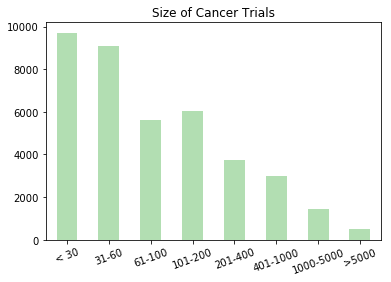

In [104]:
enrollment_counts.plot(kind='bar', title='Size of Cancer Trials', alpha=0.6, colormap='Accent', rot=20)

##### c. Are the really big ones observational? 

In [105]:
# View value counts for Interventional vs. observational
without_nulls_enrollment['Study Types'].value_counts()

Interventional    31562
Observational      7594
Name: Study Types, dtype: int64

In [106]:
# Create dummies for study type - this will enable a stacked bar graph
dummies = pd.get_dummies(without_nulls_enrollment['Study Types'], prefix_sep='')

In [107]:
# Join dummies with df
result = pd.concat([without_nulls_enrollment, dummies], axis=1)

In [108]:
# Create a groupby object that can be converted to a stacked bar graph
enrollment_by_study_type =  result.groupby('Category').sum()[['Interventional', 'Observational']]

In [109]:
# Sort the groupby object you just created
groupby_sorted = enrollment_by_study_type.sort_index(ascending=False)

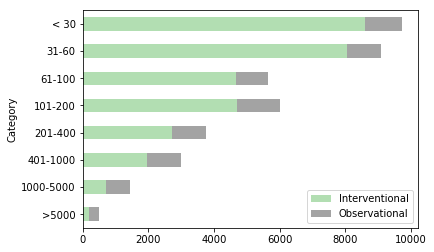

In [110]:
groupby_sorted.plot(kind='barh', stacked=True, alpha=0.6, colormap='Accent')

As you can see above, most of the smaller trials are interventional, but as the size of the trial increases, so does the percentage of observational trials.

# 5. How many interventional vs. observational trials are there?

In [111]:
trials['Study Types'].value_counts()

Interventional     35610
Observational       8200
Expanded Access      152
Name: Study Types, dtype: int64

In [112]:
trials.columns

Index(['Rank', 'NCT Number', 'Title', 'Recruitment', 'Study Results',
       'Conditions', 'Interventions', 'Sponsor/Collaborators', 'Gender', 'Age',
       'Phases', 'Enrollment', 'Funded Bys', 'Study Types', 'Study Designs',
       'Other IDs', 'First Received', 'Start Date', 'Completion Date',
       'Last Updated', 'Last Verified', 'Results First Received', 'Acronym',
       'Primary Completion Date', 'Outcome Measures', 'URL', 'Breast', 'Lung',
       'Colorectal', 'Prostate', 'Pancreatic', 'Thyroid', 'Ovarian',
       'Melanoma', 'Esophageal', 'Multiple Myeloma', 'Lymphomas', 'Leukemias',
       'Uterine', 'Bladder', 'Cervical', 'Head and Neck', 'Liver',
       'Testicular', 'Brain', 'Kidney', 'Gastric', 'Bone', 'Soft-tissue'],
      dtype='object')

/Applications/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


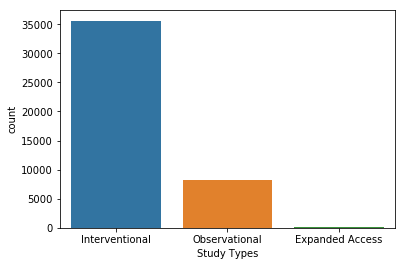

In [113]:
ax = sns.countplot(x='Study Types', data=trials)

# 6. How do interventional and observational trials differ in size?

In [114]:
# build out list of tuples with enrollment category and amount of total trials in that category
tuples = []
for cat in without_nulls_enrollment['Category'].unique().sort_values():
    tuples.append((without_nulls_enrollment.loc[without_nulls_enrollment['Category'] == cat].shape[0], cat))

Wow if you look above, I could have just done value counts. It was late...

In [115]:
tuples

[(9714, '< 30'),
 (9077, '31-60'),
 (5638, '61-100'),
 (6019, '101-200'),
 (3762, '201-400'),
 (3004, '401-1000'),
 (1446, '1000-5000'),
 (496, '>5000')]

In [116]:
# build out another list of tuples, this time with the number of interventional trials per category
int_per_cat = []
for total, cat in tuples:
    int_per_cat.append((without_nulls_enrollment.loc[(without_nulls_enrollment['Study Types'] == 'Interventional') & (without_nulls_enrollment['Category'] == cat)].shape[0], cat))

In [117]:
int_per_cat

[(8602, '< 30'),
 (8038, '31-60'),
 (4655, '61-100'),
 (4698, '101-200'),
 (2713, '201-400'),
 (1964, '401-1000'),
 (703, '1000-5000'),
 (189, '>5000')]

In [118]:
# zip together the totals and the interventionals
tot_vs_int = zip([i[0] for i in tuples], [i[0] for i in int_per_cat])

In [119]:
tot_vs_int

In [120]:
# now just get a list of the percent of interventional trials per category
percent_int_per_cat = []
for total, inter in tot_vs_int:
    percent_int_per_cat.append(float(inter)/total)

In [121]:
percent_int_per_cat

[0.885526044883673,
 0.8855348683485733,
 0.8256473926924441,
 0.780528326964612,
 0.7211589580010632,
 0.6537949400798935,
 0.48616874135546334,
 0.3810483870967742]

In [122]:
# now i need to repeat for observational
int_per_obs = []
for total, cat in tuples:
    int_per_obs.append((without_nulls_enrollment.loc[(without_nulls_enrollment['Study Types'] == 'Observational') & (without_nulls_enrollment['Category'] == cat)].shape[0], cat))
int_per_obs

[(1112, '< 30'),
 (1039, '31-60'),
 (983, '61-100'),
 (1321, '101-200'),
 (1049, '201-400'),
 (1040, '401-1000'),
 (743, '1000-5000'),
 (307, '>5000')]

In [123]:
# now zip together with totals
tot_vs_obs = zip([i[0] for i in tuples], [i[0] for i in int_per_obs])
tot_vs_obs

In [124]:
# get percentages
percent_int_per_obs = []
for tot, obs in tot_vs_obs:
    percent_int_per_obs.append(float(obs)/tot)
percent_int_per_obs

[0.11447395511632695,
 0.11446513165142669,
 0.17435260730755586,
 0.21947167303538795,
 0.2788410419989367,
 0.34620505992010653,
 0.5138312586445366,
 0.6189516129032258]

In [125]:
# create df for the percent interventionals vs categories
categories = [i[1] for i in tuples]
int_df = pd.DataFrame({'category':categories, 'percent': percent_int_per_cat, 'study-type':'interventional'})

In [126]:
int_df

,category,percent,study-type
0,< 30,0.885526,interventional
1,31-60,0.885535,interventional
2,61-100,0.825647,interventional
3,101-200,0.780528,interventional
4,201-400,0.721159,interventional
5,401-1000,0.653795,interventional
6,1000-5000,0.486169,interventional
7,>5000,0.381048,interventional


In [127]:
# create df for percent observationals vs categories
obs_df = pd.DataFrame({'category': categories, 'percent': percent_int_per_obs, 'study-type':'observational'})

In [128]:
obs_df

,category,percent,study-type
0,< 30,0.114474,observational
1,31-60,0.114465,observational
2,61-100,0.174353,observational
3,101-200,0.219472,observational
4,201-400,0.278841,observational
5,401-1000,0.346205,observational
6,1000-5000,0.513831,observational
7,>5000,0.618952,observational


In [129]:
# concat int_df and obs_df
frames = [int_df, obs_df]
df_for_plot = pd.concat(frames, ignore_index=True)

In [130]:
# multiply percent column by 100
df_for_plot['percent'] = df_for_plot['percent'] * 100

/Applications/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


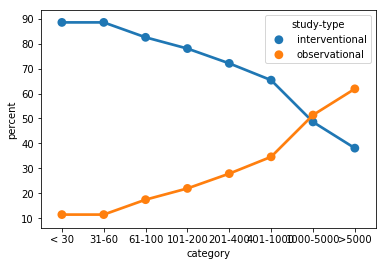

In [131]:
sns.pointplot(x='category', y='percent', hue='study-type', data=df_for_plot)

In [132]:
df_for_plot

,category,percent,study-type
0,< 30,88.552604,interventional
1,31-60,88.553487,interventional
2,61-100,82.564739,interventional
3,101-200,78.052833,interventional
4,201-400,72.115896,interventional
5,401-1000,65.379494,interventional
6,1000-5000,48.616874,interventional
7,>5000,38.104839,interventional
8,< 30,11.447396,observational
9,31-60,11.446513,observational


# 7. Left off here
Need to repeat this hbar grouped by phase

In [133]:
# Dataframe with slice of just interventionals
interventional = without_nulls_enrollment.loc[without_nulls_enrollment['Study Types'] == 'Interventional']

# Groupby 
intervent_enrollment_counts = interventional.groupby('Category').count()['Enrollment']

In [134]:
# Dataframe with slice of just observationals
observational = without_nulls_enrollment.loc[without_nulls_enrollment['Study Types'] == 'Observational']

# Groupby
observ_enrollment_counts = observational.groupby('Category').count()['Enrollment']

In [135]:
for i in intervent_enrollment_counts.values:
    print(i)

8602
8038
4655
4698
2713
1964
703
189


In [ ]:
# try using plotly to graph this
import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('mshea88', '04kbbynyqj')

In [ ]:
X = list(without_nulls_enrollment['Category'].unique())
y1 = intervent_enrollment_counts
y2 = observ_enrollment_counts

df = pd.DataFrame({'Enrollment':X, 'Interventional':y1, 'Observational':y2})

In [ ]:
data = [go.Bar(x=df['Enrollment'], y=df['Interventional']), 
       go.Bar(x=df['Enrollment'], y=df['Observational'])]

In [ ]:
layout = go.Layout(barmode='stack', title='Trial Enrollment')
fig = go.Figure(data=data, layout=layout)
url = py.plot(data, filename='enrollment-by-recruitment-type')

In [ ]:
# stipplot unfortunately doesn't work with outliers
# sns.stripplot(x="Study Types", y="Enrollment", data=without_nulls_enrollment, jitter=True)

#### Age

In [ ]:
import re

In [ ]:
trials.ix[11, 'Age']

In [ ]:
# left off trying to split age groups up, got tripped up by adult and adult, senior. maybe
# consider putting all adults and adult, seniors in a list then parsing out adult, seniors

adult_senior = 0
adult = 0
child = 0
senior = 0
child_adult_senior = 0
child_adult = 0

for row in trials.Age:
    if '(Adult, Senior)' in row:
        adult_senior += 1
    elif '(Adult)' in row:
        adult += 1
    elif 'Child, Adult, Senior' in row:
        child_adult_senior += 1
    elif 'Child, Adult' in row:
        child_adult += 1
    elif "(Child)" in row:
        child += 1
    elif "(Senior)" in row:
        senior += 1

In [ ]:
print "Senior %d" % senior
print "Adult/Senior %d" % adult_senior
print "Adult %d" % adult
print "Child/Adult/Senior %d" % child_adult_senior
print "Child/Adult %d" % child_adult
print "Child %d" % child

#### Gender

In [ ]:
trials.Gender.value_counts()

### Convert date columns to proper format
First Recieved, Start Date, Completion Date, Results First Received all need to be converted to datetime

In [ ]:
# Convert first received to datetime
trials['First Received'] = pd.to_datetime(trials['First Received'], infer_datetime_format = True)
# trials['Start Date'] = pd.to_datetime(trials['Start Date'], errors='coerce')
# trials['Completion Date'] = pd.to_datetime(trials['Completion Date'], errors='coerce')
# trials['Results First Received'] = pd.to_datetime(trials['Results First Received'], errors='coerce')
# trials['Primary Completion Date'] = pd.to_datetime(trials['Primary Completion Date'], errors='coerce')

### Trends over time visualizations
#### View phase of trials over time

In [ ]:
# Create new df object with date of First Received as index
over_time = trials[['Phases']].set_index(trials['First Received'])

# Drop NaNs (there are a considerable number)
over_time.dropna(axis=0, inplace=True)

# Limit to before 2016
over_time = over_time[over_time.index < '20160101']

# Create columns for each phase
over_time_dummies = pd.get_dummies(over_time, prefix='', prefix_sep='')



# # Plot phases over time
# from matplotlib.pyplot import colormaps
# over_time_dummies.resample('A').sum().plot(colormap='Set1', figsize=(10,7))

# # List of legend values
# legend_vals = ['Phase 2', 'Phase 1', 'Phase 3', 'Phase 1|Phase 2', 'Phase 4', 'Phase 0', 'Phase 2|Phase 3']

# for rank, column in enumerate(legend_vals):   
#     # Add a text label to the right end of every line. Most of the code below  
#     # is adding specific offsets y position because some labels overlapped.  
#     y_pos = over_time_dummies[column].values[-1] - 0.5  
#     if column == "Phase 2":  
#         y_pos += 0.5  
#     elif column == "Phase 1":  
#         y_pos -= 0.5  
#     elif column == "Phase 3":  
#         y_pos += 0.75  
#     elif column == "Phase 1|Phase2":  
#         y_pos -= 0.25  
#     elif column == "Phase 4":  
#         y_pos += 1.25  
#     elif column == "Phase 0":  
#         y_pos += 0.25  
#     elif column == "Phase 2|Phase 3":  
#         y_pos -= 0.75  

    # Again, make sure that all labels are large enough to be easily read  
    # by the viewer.  
#     plt.text(2011.5, y_pos, column, fontsize=14)

In [ ]:
resampled = over_time_dummies.resample('A').sum()

In [ ]:
# resampled.to_csv('phase_over_time', encoding ='utf-8')

In [ ]:
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  

In [ ]:
# You typically want your plot to be ~1.33x wider than tall. This plot is a rare    
# exception because of the number of lines being plotted on it.    
# Common sizes: (10, 7.5) and (12, 9)    
plt.figure(figsize=(12, 14))    
  
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
  
# Limit the range of the plot to only where the data is.    
# Avoid unnecessary whitespace.    
plt.ylim(0, 400)    
plt.xlim(2007, 2016)    
  
# Make sure your axis ticks are large enough to be easily read.    
# You don't want your viewers squinting to read your plot.    
plt.yticks(range(0, 400, 100), [str(x) for x in range(0, 400, 100)], fontsize=14)    
plt.xticks(fontsize=14)    
  
# Provide tick lines across the plot to help your viewers trace along    
# the axis ticks. Make sure that the lines are light and small so they    
# don't obscure the primary data lines.    
for y in range(10, 400, 100):    
    plt.plot(range(2007, 2016), [y] * len(range(2007, 2016)), "--", lw=0.5, color="black", alpha=0.3)    

# Remove the tick marks; they are unnecessary with the tick lines we just plotted.    
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")    
  
# Now that the plot is prepared, it's time to actually plot the data!    
# Note that I plotted the majors in order of the highest % in the final year.    
# List of legend values
legend_vals = ['Phase 2', 'Phase 1', 'Phase 3', 'Phase 1|Phase 2', 'Phase 4', 'Phase 0', 'Phase 2|Phase 3']

for rank, column in enumerate(legend_vals):      
    # Plot each line separately with its own color, using the Tableau 20    
    # color set in order.    
    plt.plot(resampled.index.year,    
            resampled[column].values,    
            lw=2.5, color=tableau20[rank]) 
    # Add a text label to the right end of every line. Most of the code below  
    # is adding specific offsets y position because some labels overlapped.  
    y_pos = over_time_dummies[column].values[-1] - 0.5  
    if column == "Phase 2":  
        y_pos += 0.5  
    elif column == "Phase 1":  
        y_pos -= 0.5  
    elif column == "Phase 3":  
        y_pos += 0.75  
    elif column == "Phase 1|Phase2":  
        y_pos -= 0.25  
    elif column == "Phase 4":  
        y_pos += 1.25  
    elif column == "Phase 0":  
        y_pos += 0.25  
    elif column == "Phase 2|Phase 3":  
        y_pos -= 0.75   
        
    # Again, make sure that all labels are large enough to be easily read    
    # by the viewer.    
    plt.text(2011.5, y_pos, column, fontsize=14, color=tableau20[rank])    

# matplotlib's title() call centers the title on the plot, but not the graph,    
# so I used the text() call to customize where the title goes.    
  
# Make the title big enough so it spans the entire plot, but don't make it    
# so big that it requires two lines to show.    
  
# Note that if the title is descriptive enough, it is unnecessary to include    
# axis labels; they are self-evident, in this plot's case.    
plt.text(1995, 93, "Percentage of Bachelor's degrees conferred to women in the U.S.A."    
       ", by major (1970-2012)", fontsize=17, ha="center")    
  
# Always include your data source(s) and copyright notice! And for your    
# data sources, tell your viewers exactly where the data came from,    
# preferably with a direct link to the data. Just telling your viewers    
# that you used data from the "U.S. Census Bureau" is completely useless:    
# the U.S. Census Bureau provides all kinds of data, so how are your    
# viewers supposed to know which data set you used?    
plt.text(1966, -8, "Data source: nces.ed.gov/programs/digest/2013menu_tables.asp"    
       "\nAuthor: Randy Olson (randalolson.com / @randal_olson)"    
       "\nNote: Some majors are missing because the historical data "    
       "is not available for them", fontsize=10)    

### 8 Clean Text Data
#### Sponsor/Collaborators column
Split cells with multiple sponsors, then create a new df with a column for each sponsor. Then join with original dataframe.

In [ ]:
# split pipe delimited sponsor names into a list in each cell
s = trials['Sponsor/Collaborators'].str.split('|')

In [ ]:
# The lead sponsor is the first one listed - generate new list with only lead sponsor
lead_sponsors = [row[0] for row in s]

In [ ]:
# Turn lead_sponsors list to a pandas series
lead_sponsors_series = pd.Series(lead_sponsors)

In [ ]:
# Get value counts
lead_sponsors_series.value_counts().sort_values(ascending=False)[:50]

In [ ]:
lead_sponsors[:100]

In [ ]:
# build out data structure to be converted to dataframe - essentially dummy columns for each sponsor
random_list = []
for row in s:
    sponsors_dict = {}
    for item in row:
        sponsors_dict[item] = 1
    random_list.append(sponsors_dict)

In [ ]:
# create dataframe
sponsors_df = pd.DataFrame(random_list)

In [ ]:
# over 10k columns... remove some? no, let's keep it as is for now
sponsors_df.shape

In [ ]:
sponsors_df.sum().sort_values(ascending=False)

In [ ]:
# join sponsors_df with trials
# result = pd.concat([trials, sponsors_df], axis=1)

#### Funded Bys column
Split cells with multiple sponsors, then create a new df with a column for each sponsor. Then join with original dataframe.

In [ ]:
# Split cells with multiple values
t = trials['Funded Bys'].str.split('|')

In [ ]:
# Build out data structure (list of dictionaries) that can be converted to a dataframe 
# with a column for each funder
funded_by_list = []
for row in t:
    temp_dict = {}
    for z in row:
        temp_dict[z]=1
    funded_by_list.append(temp_dict)

In [ ]:
# Convert to dataframe
funders_df = pd.DataFrame(funded_by_list)

In [ ]:
# Join with result dataframe
result = pd.concat([trials, funders_df], axis=1)

#### View funded bys over time

In [ ]:
# convert 'First Received' field to datetime
result['First Received'] = pd.to_datetime(result['First Received'], infer_datetime_format = True)

In [ ]:
# Create new df object with columns for each of the funded by columns and index date first received
funded_bys = result.iloc[:, -4:].set_index(result['First Received'])

# Plot this data, removing 2016 data
funded_bys['01/01/2007': '12/31/2015'].resample('A').sum().plot(colormap='Set1', figsize=(10,7))

### Time between study start and completion; Time between study start and results recevied

In [ ]:
# Create slice with columns of interest
duration = second_result[['NCT Number', 'Conditions', 'Gender', 'Age', 'Phases', 'Enrollment', 'Funded Bys', 'Study Types',
                         'First Received', 'Primary Completion Date']]

In [ ]:
# Further slice to only include studies with primary completion date on or before present
duration = duration[duration['Primary Completion Date'] < '2016-08-27']

In [ ]:
# Convert enrollment to int
duration.Enrollment = pd.to_numeric(duration.Enrollment, errors='coerce')

In [ ]:
# bucket enrollment
bins = [0,50,100,200,300,500,1000,50000]
bucket_names = ['<50', '<100', '<200', '<300', '<500', '<1000', '>1000']

duration['enroll_buckets'] = pd.cut(duration.Enrollment, bins, labels=bucket_names)

In [ ]:
# Group by enrollment
duration.groupby('enroll_buckets').mean()

In [ ]:
# Check for any nulls
duration.isnull().sum()

In [ ]:
duration['Duration'] = duration['Primary Completion Date'] - duration['First Received']

In [ ]:
duration['Duration_int'] = duration.Duration.dt.days

In [ ]:
duration.groupby('Phases').mean()

In [ ]:
duration.groupby('Funded Bys').mean().sort_values(by='Duration_int')

In [ ]:
duration[duration.Duration_int < 0]

In [ ]:
# check nulls of First Received and Primary Completion Date
print second_result['First Received'].isnull().sum()
print second_result['Primary Completion Date'].isnull().sum()

In [ ]:
second_result['Primary Completion Date'] - second_result['First Received']

In [ ]:
second_result.iloc[1,:]

In [ ]:
second_result.Recruitment.value_counts()

In [ ]:
trials.columns

In [ ]:
# some value counts
print trials.Recruitment.value_counts(), '\n'
print trials['Study Results'].value_counts(), '\n'
print trials.Gender.value_counts(), '\n'
print trials.Phases.value_counts(), '\n'
print trials['Funded Bys'].value_counts(), '\n'
print trials['Study Types'].value_counts(), '\n'
print trials['Study Results'].value_counts()

In [ ]:
# how many unique conditions, interventions, and sponsors are listed?
print len(trials.Conditions.unique())
print len(trials.Interventions.unique())
print len(trials['Sponsor/Collaborators'].unique())
print len(trials.Age.unique())

In [ ]:
# View nulls
pd.isnull(trials).sum()

In [ ]:
# trials.set_index(trials['First Received'], inplace=True)

# plot trials over time - wonder what caused massive btwn 2012 and 2015?
# trials['NCT Number'].resample('A').count().plot()

# plot the count of trials per year that have results over time
# trials[trials['Study Results'] == 'Has Results']['NCT Number'].resample('A').count().plot()